In [58]:
import sys
import os

# Adjust this path to point to the root of your project (the one containing `src/`)
project_root = os.path.abspath("..")  # or "../../" depending on where notebook is
if project_root not in sys.path:
    sys.path.insert(0, project_root)

In [59]:
import numpy as np
from src.lvmogp.lvmogp_ssvi import LVMOGP_SSVI_Torch
import pathlib as pl
import os
from src.lvmogp.lvmogp_test_functions import TestFun

os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [60]:
import torch
from src.lvmogp.lvmogp_ssvi import LVMOGP_SSVI_Torch      
from src.gp_dataclasses  import GPSSVIConfig
import matplotlib.pyplot as plt

torch.set_default_dtype(torch.float64)

# Quick Notebook Showing how to fit the LVMOGP

In [52]:
seed=1
surface_type = 'linear_relation'
n_new_points=20
n_new_funs = 10
data_type_name = f'two_observed_{n_new_funs}_new'
n_fun = 2 + n_new_funs
total_train = 30*2 + 3 * n_new_points
n_points = [10]*2 + [n_new_points]*n_new_funs
n_train = n_points

set_opt_seed = False

same_points = False
plot_figs = True

train_inducing = True
domain = [0, 2]
latent_dims = 2
latent_dims_lvmogp = 2
observed_dims = 1
max_points = 60

noise = 0.05
n_grid_points = 100
continuous_dims = ['x1', 'x2'][:observed_dims]
lengthscales_x = [0.3, 0.3]
lengthscales_h = [0.4, 0.4, 0.4, 0.4, 0.4, 0.4][:latent_dims]


test_fun = TestFun(domain=domain, seed=seed, n_fun=n_fun,
                   observed_dims=observed_dims, test_type=surface_type, latent_dims=latent_dims, max_points=max_points,
                   noise=noise, n_grid_points=n_grid_points, same_points=same_points, lengthscales_X=lengthscales_x,
                   lengthscales_H=lengthscales_h)

## Generate and Plot the Data

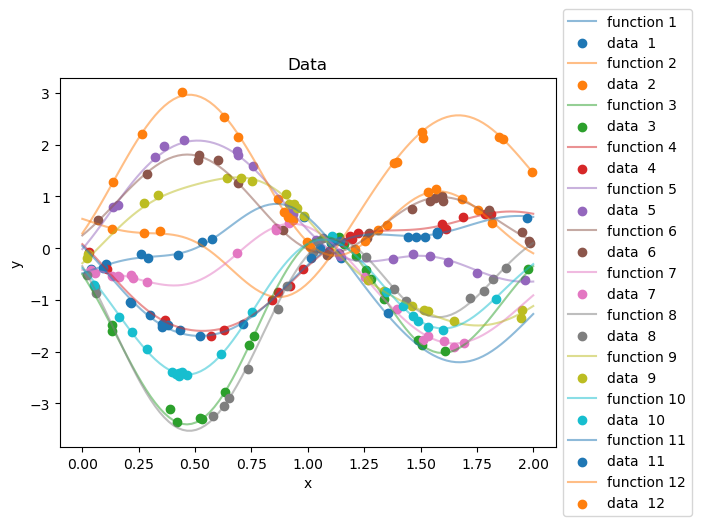

In [ ]:
data_X, fun_nos, data_y = test_fun.create_data(n_points=n_points)


if plot_figs:
    test_fun.plot_data(n_points)

## Fit the LVMOGP

Randomly initialise the hyperparameters

In [54]:
torch.set_default_dtype(torch.float64)

# random H initialisation (unchanged values, just Torch)
H_mean = torch.tensor(
    np.random.uniform(-1, 1, (n_fun, latent_dims_lvmogp)),
    dtype=torch.float64
)
H_var  = torch.full_like(H_mean, 1e-6)

# likelihood noise (same formula as before)
lik_variance = np.var(data_y) * 0.01
n_u          =  70                     # number of inducing inputs

Make the LVMOGP

In [55]:
Y_torch  = torch.tensor(data_y , dtype=torch.float64)
X_torch  = torch.tensor(data_X , dtype=torch.float64)
fn_torch = torch.tensor(fun_nos, dtype=torch.float64)

# H_mean = (n_fun, Q)
H_mean_all = torch.tensor(H_mean[fun_nos.flatten()], dtype=torch.float64)  # shape (N, Q)
H_var_all  = torch.full_like(H_mean_all, 1e-6)

model = LVMOGP_SSVI_Torch(
    data        = Y_torch,
    X_data      = X_torch,
    X_data_fn   = fn_torch,
    H_data_mean = H_mean_all,
    H_data_var  = H_var_all,
    num_inducing_variables = n_u,
)


C:\Users\mtret\AppData\Local\Temp\ipykernel_62512\4154977831.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  H_mean_all = torch.tensor(H_mean[fun_nos.flatten()], dtype=torch.float64)  # shape (N, Q)


In [56]:
from src.gp_dataclasses import (
    GPSSVIConfig,
    LR,
    Rho,
    Training,
    InnerIters,
    InducingConfig,
    InitXDistSsvi,
)


cfg = GPSSVIConfig(
    device="cpu",                    
    debug=False,
    jitter=5e-6,
    max_exp=60.0,
    q_latent=latent_dims_lvmogp,
    init_signal_to_noise_ratio=30.0,
    num_u_samples_per_iter=2,

    lr=LR(
        x=1e-3,
        hyp=1e-2,
        alpha=5e-3,
    ),

    rho=Rho(
        t0=100.0,
        k=0.6,
    ),

    training=Training(
        batch_size=min(128, len(data_X)),
        total_iters=400,
        inner_iters=InnerIters(
            start=50,
            after=40,
            switch=50,
        ),
    ),

    inducing=InducingConfig(
        n_inducing=n_u,
        selection="perm",
        seed=19,
    ),

    init_latent_dist=InitXDistSsvi(
        method="default",
        custom_path=None,
    ),
)


Train it

In [57]:
print(cfg)
results = model.ssvi_train(cfg)          # trains in Torch

GPSSVIConfig(device='cpu', debug=False, jitter=5e-06, max_exp=60.0, q_latent=2, init_signal_to_noise_ratio=30.0, num_u_samples_per_iter=2, lr=LR(x=0.001, hyp=0.01, alpha=0.005), rho=Rho(t0=100.0, k=0.6), training=Training(batch_size=128, total_iters=400, inner_iters=InnerIters(start=50, after=40, switch=50)), inducing=InducingConfig(n_inducing=70, selection='perm', seed=19), init_latent_dist=InitXDistSsvi(method='default', custom_path=None))
Config auto selected device: cpu
num_u_samples_per_iter: 2
Data: N=220, D=1, D_x=1, Q=2, num_fns=12
snr: 30.0


  0%|▏                                                              | 1/400 [00:03<23:56,  3.60s/it]


DATASET FULL ELBO @   1: -5.4534e+03  LL=-3.0474e+03  KL_H=2.0089e+03  KL_U=3.9710e+02


  4%|██▊                                                           | 18/400 [01:06<23:30,  3.69s/it]


KeyboardInterrupt: 

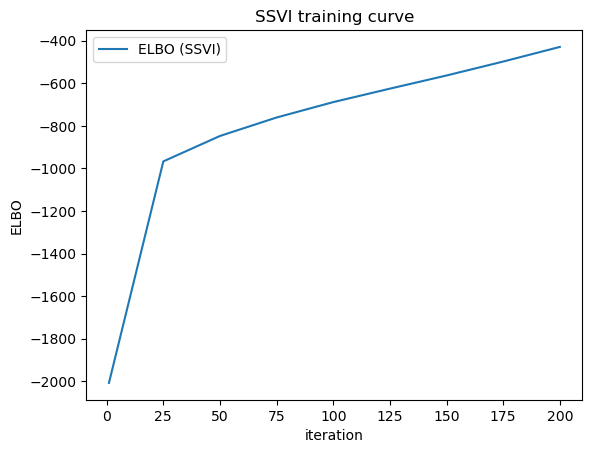

In [ ]:
import matplotlib.pyplot as plt

iters = results["elbo_iters"]    # list saved by the trainer
elbo  = results["elbo_vals"]     # same as before

plt.plot(iters, elbo, label="ELBO (SSVI)")
plt.xlabel("iteration")
plt.ylabel("ELBO")
plt.title("SSVI training curve")
plt.legend()
plt.show()

Predict on new points

In [28]:
x_new = torch.linspace(domain[0], domain[1], 100,
                       dtype=torch.get_default_dtype(), device=model.DEV).view(-1, 1)   # (100,1)
xs_new = x_new.repeat(n_fun, 1)                                           # (100*n_fun, 1)

fun_ids = torch.unique(fn_torch, sorted=True)                      # (n_fun,)
X_data_fun_new = torch.cat([torch.full((len(x_new),), fid,
                                      dtype=torch.long, device=model.DEV)
                           for fid in fun_ids])                     # (100*n_fun,)

# Use format 1: (X_new, X_new_fn) - much cleaner!
lvm_mu, lvm_sig2 = model.predict_y((xs_new, X_data_fun_new))

Plot the predictions and the latent coordinates

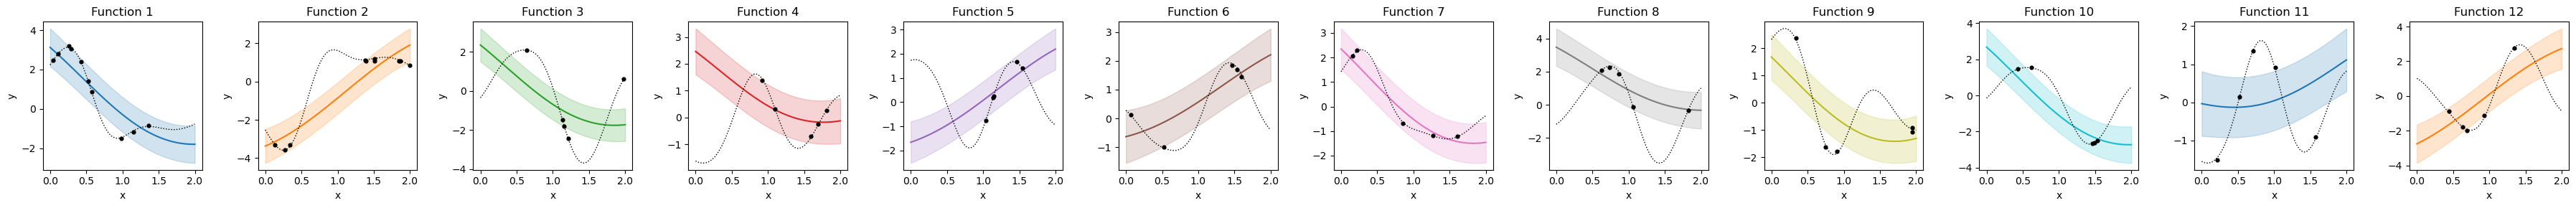

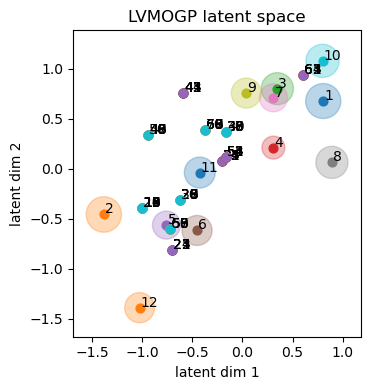

In [29]:
from matplotlib.patches import Ellipse
import numpy as np

# SETTINGS  
n_fun        = len(test_fun.functions)          # number of functions
pts_per_fun  = 100                              # x-points per function
palette      = (plt.rcParams['axes.prop_cycle']
                .by_key()['color']) * 10        # plenty of distinct colours

#  1. Ground-truth curves  
ys_new = []
for f in test_fun.functions:
    y_tf, _ = f.predict_y(x_new.cpu().numpy())              # GPflow → NumPy
    ys_new.append(torch.from_numpy(y_tf.numpy())            # NumPy → Torch
                       .to(dtype=x_new.dtype,
                           device=x_new.device))

#  2. LVMOGP predictions vs. ground-truth 
fig, axs = plt.subplots(1, ncols=n_fun, figsize=(3*n_fun, 3))
if n_fun == 1:
    axs = [axs]  # Make it iterable for single function case
else:
    axs = axs.flatten()

x_np   = x_new.cpu().numpy().flatten()                      # (100,)

lvm_mu_np = lvm_mu.cpu().numpy().squeeze()                  # (n_fun*100,)
lvm_sig2_np = lvm_sig2.cpu().numpy().squeeze()              # (n_fun*100,)

# Check if reshaping is valid
expected_size = n_fun * pts_per_fun
if lvm_mu_np.size != expected_size:
    print(f"Warning: Expected {expected_size} elements, got {lvm_mu_np.size}")
    pts_per_fun = lvm_mu_np.size // n_fun

mu_np = lvm_mu_np.reshape(n_fun, pts_per_fun)               # (n_fun, pts_per_fun)
s2_np = lvm_sig2_np.reshape(n_fun, pts_per_fun)

for i in range(n_fun):
    mu_i, s2_i = mu_np[i], s2_np[i]

    axs[i].plot(x_np[:pts_per_fun], mu_i, color=palette[i], lw=1.5)  # prediction
    axs[i].fill_between(x_np[:pts_per_fun],                          # 95 % CI
                        mu_i + 2.0*np.sqrt(np.maximum(s2_i, 1e-8)),  
                        mu_i - 2.0*np.sqrt(np.maximum(s2_i, 1e-8)),
                        alpha=0.20, color=palette[i])

    axs[i].scatter(test_fun.xs[i][:n_points[i]],            # training pts
                   test_fun.ys[i][:n_points[i]],
                   color='k', s=12, zorder=3)

    axs[i].plot(x_np[:pts_per_fun],                         # ground-truth
                ys_new[i].cpu().numpy().flatten()[:pts_per_fun],
                linestyle=':', color='k', lw=1)

    axs[i].set_title(f'Function {i+1}')
    axs[i].set_xlabel('x');  axs[i].set_ylabel('y')

plt.tight_layout();  plt.show()

#  3. Latent space (Q = 2)
fig, axH = plt.subplots(figsize=(4, 4))

H_mean_trained = model.results["H_mean"].cpu().numpy()     # (num_fns, Q)
H_var_trained = model.results["H_log_s2"].exp().cpu().numpy()  # (num_fns, Q)

H_mean_fun = H_mean_trained  # (n_fun, Q)
H_var_fun = H_var_trained    # (n_fun, Q)

for i, (m, v) in enumerate(zip(H_mean_fun, H_var_fun)):
    axH.scatter(m[0], m[1], color=palette[i], s=40, zorder=3) 
    
    offset = np.array([0.01, 0.01])
    axH.annotate(str(i+1), m + offset)

    width = 1.95 * np.sqrt(np.maximum(v[0], 1e-6))   # Avoid tiny ellipses
    height = 1.95 * np.sqrt(np.maximum(v[1], 1e-6))
    
    ell = Ellipse(xy=m,
                  width=width,
                  height=height,
                  angle=0,
                  alpha=0.30,
                  color=palette[i])
    axH.add_patch(ell)

axH.set_title('LVMOGP latent space')
axH.set_xlabel('latent dim 1')
axH.set_ylabel('latent dim 2')
axH.set_aspect('equal', adjustable='box')
plt.tight_layout()
plt.show()